<a href="https://colab.research.google.com/github/SanBartolome/IA-diploma-course-2021/blob/main/Desafio7_San_Bartolom%C3%A9_Carlos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 7 - Tarea

<img src='https://escuela.pucp.edu.pe/gobierno/wp-content/uploads/2015/04/logo-pucp-full-color-300x88.png' width=200px>


Dr. Edwin Villanueva, Ing. Daniel Saromo

<font color='orange'>Entorno `GridEnvironment` con aprendizaje por Q-Learning.</font>


El presente desafio aborda la experimentacion con agentes de aprendizaje por refuerzo Q-learning en entornos grid. La implementacion de la clase del entorno GridEnvironment y el agente Q-learning ya estan implementadas. El desafío se encuentra al final del notebook.

Se requieren tener los archivos [`mdp.py`](https://github.com/aimacode/aima-python/blob/master/mdp.py) y [`utils.py`](https://github.com/aimacode/aima-python/blob/master/utils.py).

Completar con su código los campos requeridos y subir su notebook solucionado a la plataforma PAIDEIA. El formato del nombre del notebook es: `Desafio7_APELLIDOPATERNO_NOMBRE.ipynb`.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto. Respetar los lineamientos de la entrega de archivo, ya que influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA. No se aceptarán entregas luego de haberse publicado el solucionario de la tarea.

## Descarga de archivos hacia el directorio temporal del notebook

In [1]:
!wget -N https://raw.githubusercontent.com/DanielSaromo/Courses_DataFiles/main/GameAI/mdp.py
!wget -N https://raw.githubusercontent.com/DanielSaromo/Courses_DataFiles/main/GameAI/utils.py

--2022-01-22 17:28:00--  https://raw.githubusercontent.com/DanielSaromo/Courses_DataFiles/main/GameAI/mdp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16758 (16K) [text/plain]
Saving to: ‘mdp.py’

mdp.py              100%[===================>]  16.37K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2022-01-22 17:28:00 (56.8 MB/s) - ‘mdp.py’ saved [16758/16758]

--2022-01-22 17:28:00--  https://raw.githubusercontent.com/DanielSaromo/Courses_DataFiles/main/GameAI/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting 

###  Clase <b>GridEnvironment</b>

La clase `GridEnvironment` define un entorno MDP (Proceso de Decisiones de Markov) para entornos grids (laberintos), como el ejemplo usado en clase. Las probabilidades de transicion son `0.8` para moverse en la dirección pretendida y `0.1` de moverse a un estado lateral. El constructor recibe:

- `grid`: un array de listas de numeros definiendo los rewards del grid del entorno. Valores None indican un obstaculo
- `terminals`: lista de estados terminales
- `initial`: estado inicial
- `gamma`: factor de descuento

La clase mantiene el estado actual (`current_state`), el cual se inicializa en estado `initial` y se modifica con cada paso que se dé en el entorno (llamada a `step()`), devolviendo el nuevo estado, el reward y un flag `done` que indica si el entorno ha caido en un estado terminal. El modelo de transicion de cada estado es accesible a través de la funcion `T(s,a)` que devuelve una lista de tuplas `(prob, s')` para cada estado vecino `s'` del estado `s` ejecutando la accion `a` (`prob` es la probabilidad de transicionar de `s` a `s'` con accion `a`)

In [2]:
from collections import defaultdict
import random
import operator
import numpy as np

EAST, NORTH, WEST, SOUTH = (1, 0), (0, 1), (-1, 0), (0, -1)
LEFT, RIGHT = +1, -1
        
class GridEnvironment:
    def __init__(self, grid, terminals, initial=(0, 0), gamma=.9):
        grid.reverse()     # para que fila 0 sea la de abajo, no la de arriba
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        self.initial_state = initial
        self.current_state = initial
        self.terminals = terminals
        self.gamma = gamma
        self.actionlist = [EAST, NORTH, WEST, SOUTH] 

        self.rewards = {}        # diccionario de rewards
        self.states = set()     # conjunto de estados diferentes
        for x in range(self.cols):   # obtiene todos los estados y rewards del grid
            for y in range(self.rows):
                if grid[y][x]:  # Si la celda no es None (Prohibida), agrega el estado y reward
                    self.states.add((x, y))
                    self.rewards[(x, y)] = grid[y][x]
            
        self.transition_probs = {}  # almacena los diccionarios de probabilidades de transicion
        for s in self.states:
            self.transition_probs[s] = {}  # diccionario de probabilidades de transicion de los vecinos de estado s
            for a in self.actionlist:
                self.transition_probs[s][a] = self.get_transition_probs(s, a)
                
    def get_transition_probs(self, state, action): 
        # Hay 0.8 de probabilidad de moverse en la dirección pretendida y 0.1 de moverse por cada lateral. 
        if action:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, self.turn_right(action))),
                    (0.1, self.go(state, self.turn_left(action)))]
        else:
            return [(0.0, state)]
        
    def go(self, state, direction):
        """Retorna el estado que resultaria de ir en la direccion pasada, si el ambiente fuese deterministico """
        state1 = tuple(map(operator.add, state, direction))
        return state1 if state1 in self.states else state    
    
    def turn_heading(self, heading, inc, headings=[EAST, NORTH, WEST, SOUTH]):
        return headings[(headings.index(heading) + inc) % len(headings)]

    def turn_right(self, heading):
        return self.turn_heading(heading, RIGHT)

    def turn_left(self, heading):
        return self.turn_heading(heading, LEFT) 
    
    def T(self, s, a):  # Retorna los estados vecinos y sus prob de transicion, tuplas (prob, s'), para el estado  s y accion a
        return self.transition_probs[s][a] if a else [(0.0, s)]

    def R(self, state): # retorna el reward de un estado
        return self.rewards[state]    
    
    def actions(self, state): # retorna la lista de acciones posibles en un estado 
        if state in self.terminals:
            return [None]
        else:
            return self.actionlist    
    
    def reset(self):  # Reseta el Entorno
        self.current_state = self.initial_state
        return self.current_state, self.rewards[self.current_state]
    
    def step(self, action): # Ejecuta un paso el entorno. Retorna el nuevo estado, el reward y flag de que es estado terminal
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for probability_state in self.T(self.current_state, action):
            probability, next_state = probability_state
            cumulative_probability += probability
            if x < cumulative_probability:
                break
        self.current_state = next_state
        done = True if current_state in self.terminals else False
        return self.current_state, self.rewards[self.current_state], done
    
    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""
        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                               for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {(1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})
    
    def print_policy(self, policy):
        """Imprime la politica"""
        header=None
        sep='   '
        numfmt='{}'
        table = self.to_arrows(policy)
        justs = ['rjust' if hasattr(x, '__int__') else 'ljust' for x in table[0]]

        if header:
            table.insert(0, header)

        table = [[numfmt.format(x) if hasattr(x, '__int__') else x for x in row]
                 for row in table]

        sizes = list(
            map(lambda seq: max(map(len, seq)),
                list(zip(*[map(str, row) for row in table]))))

        for row in table:
            print(sep.join(getattr(
                str(x), j)(size) for (j, size, x) in zip(justs, sizes, row)))
            

###  Entorno para experimentar </b>
Para experimentar,  se usará el entorno MDP definido abajo. El factor de descuento es $\gamma = 0.9$ (en los ejemplos de clase se usó $\gamma = 1$). Las recompensas son **`-0.1`** en estados no terminales y **`+5`** y **`-5`** en estados terminales.   

In [3]:
# el grid que se vió en clase
#grid = [[-0.04, -0.04, -0.04, +1],
#        [-0.04,  None, -0.04, -1],
#        [-0.04, -0.04, -0.04, -0.04]]

# el grid de este desafio
grid = [
    [None, None, None, None, None, None, None, None, None, None, None], 
    [None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None, +5.0, None], 
    [None, -0.1, None, None, None, None, None, None, None, -0.1, None], 
    [None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None], 
    [None, -0.1, None, None, None, None, None, None, None, None, None], 
    [None, -0.1, None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None], 
    [None, -0.1, None, None, None, None, None, -0.1, None, -0.1, None], 
    [None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None, -0.1, None], 
    [None, None, None, None, None, -0.1, None, -0.1, None, -0.1, None], 
    [None, -5.0, -0.1, -0.1, -0.1, -0.1, None, -0.1, None, -0.1, None], 
    [None, None, None, None, None, None, None, None, None, None, None]
]


## Clase <b>QLearningAgent</b>

Esta clase define un agente exploratorio Q-Learning. Este evita aprender el modelo de transicion ya que los Q-valores de un estado-action puede ser relacionado directamente a los Q-valores de los estado-action vecinos 

In [4]:
class QLearningAgent:
    
    def __init__(self, mdp, Ne, Rplus, alpha=None):

        self.gamma = mdp.gamma    # factor de descuento (definido en el MDP)
        self.terminals = mdp.terminals   # estados terminales (definido en el MDP)
        self.all_act = mdp.actionlist  # acciones posibles
        self.Ne = Ne        # limite de iteraciones de la funcion de exploracion
        self.Rplus = Rplus  # Recompensa que tienen los estados (o q-estados) antes del limite de iteraciones Ne
        self.Q = defaultdict(float)   # almacena los q-valores
        self.Nsa = defaultdict(float) # almacena la tabla de frecuencias state-action
        self.s = None    # estado anterior
        self.a = None    # ultima accion ejecutada
        self.r = None    # recompensa de estado anterior

        if alpha:
            self.alpha = alpha   # alpha es la taza de aprendizaje. Debe disminuir con el numero de visitas al estado para que las utilidades converjan
        else:
            self.alpha = lambda n: 1./(1+n) 

    def analyze_if_state_is_terminal(self, state):
        return state in self.terminals

    def f(self, u, n): 
        """ Funcion de exploración. Retorna un valor de utilidad fijo (Rplus) hasta que el agente visita Ne veces el state-action """
        if n < self.Ne:
            return self.Rplus
        else:
            return u

    def actions_in_state(self, state):
        """ Retorna el conbjunto de acciones posibles del estado pasado. Util para max y argmax. """
        if self.analyze_if_state_is_terminal(state):
            return [None]
        else:
            return self.all_act

    # Programa del agente Q-learning    
    def __call__(self, percept):    
        """ Este es el programa del agente que es llamado en cada step, recibe un percept y retorna una accion """
        s1, r1 = self.update_state(percept)
        Q, Nsa, s, a, r = self.Q, self.Nsa, self.s, self.a, self.r
        alpha, gamma = self.alpha, self.gamma
        actions_in_state = self.actions_in_state

        if self.analyze_if_state_is_terminal(s):
            Q[s, None] = r1
        if s is not None:
            Nsa[s, a] += 1
            Q[s, a] += alpha(Nsa[s, a]) * (r + gamma * max(Q[s1, a1] for a1 in actions_in_state(s1)) - Q[s, a])
        if self.analyze_if_state_is_terminal(s):
            self.s = self.a = self.r = None
        else:
            self.s, self.r = s1, r1
            self.a = max(actions_in_state(s1), key=lambda a1: self.f(Q[s1, a1], Nsa[s1, a1])) # funciona como argmax, devuelve la accion con mayor f

        return self.a

    def update_state(self, percept):
        ''' To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)'''
        return percept

## Probando el agente  <b>Q-learning</b>

Vamos a instanciar un agente Q-learning para aprender una politica en nuestro entorno de prueba `grid`. Los parametros del agente son los siguientes: `Ne = 10`, `Rplus = 2`, `alpha` como indica el libro guía en la nota inferior en la **pagina 837**:

In [5]:
# Instancia el entorno del grid
#environment = GridEnvironment(grid, terminals=[(3, 2), (3, 1)], initial=(0, 0), gamma=0.9) # grid de la clase
environment = GridEnvironment(grid, terminals=[(1, 1), (9, 9)], initial=(3, 1), gamma=0.9) # 

# Instancia un agente Q-learning 
agent = QLearningAgent(environment, Ne=10, Rplus=2, alpha=lambda n: 60./(59+n))  # alpha: suggestion from aima book

# Ejecuta episodios del agente en el entorno
TRIALS = 4000

training_rewards = []

for e in range(TRIALS):   # Por cada trial
    current_state, current_reward = environment.reset()
    score_trial = current_reward   # el score del episodio es la suma acumulada de rewards en el episodio 
    while True:  # ejecuta steps del entorno hasta llegar a un estado terminal
        percept = (current_state, current_reward)  # la percepcion del agente es la tupla (state, reward)
        action  = agent(percept)  # llama al programa del agente, pasandole el percept y espera una accion a ejecutar
        current_state, current_reward, done = environment.step(action) # ejecuta la accion en el entorno, 
        score_trial += current_reward
        if done:
            print("Trial: {}/{}, Score: {}".format(e, TRIALS, score_trial))
            training_rewards.append(score_trial)
            break

Trial: 0/4000, Score: -68.6999999999998
Trial: 1/4000, Score: -23.999999999999964
Trial: 2/4000, Score: -12.900000000000002
Trial: 3/4000, Score: -10.4
Trial: 4/4000, Score: -10.3
Trial: 5/4000, Score: -10.3
Trial: 6/4000, Score: -10.3
Trial: 7/4000, Score: -10.3
Trial: 8/4000, Score: -10.3
Trial: 9/4000, Score: -10.3
Trial: 10/4000, Score: -10.5
Trial: 11/4000, Score: -10.4
Trial: 12/4000, Score: -12.0
Trial: 13/4000, Score: -7.6999999999999815
Trial: 14/4000, Score: -23.300000000000203
Trial: 15/4000, Score: 3.000000000000009
Trial: 16/4000, Score: 2.2000000000000117
Trial: 17/4000, Score: 7.6
Trial: 18/4000, Score: 7.399999999999999
Trial: 19/4000, Score: 5.899999999999999
Trial: 20/4000, Score: -71.29999999999966
Trial: 21/4000, Score: -25.20000000000023
Trial: 22/4000, Score: 0.20000000000001883
Trial: 23/4000, Score: 3.7000000000000064
Trial: 24/4000, Score: 6.499999999999998
Trial: 25/4000, Score: -10.8
Trial: 26/4000, Score: -1.4999999999999751
Trial: 27/4000, Score: -33.000000

Ahora veamos el diccionario de los Q-valores aprendidos. Las claves son pares state-action. Las diferentes acciones corresponden a:

NORTH = (0, 1)  
SOUTH = (0,-1)  
WEST = (-1, 0)  
EAST = (1, 0)

In [6]:
Qvalues = agent.Q
#print(Qvalues)

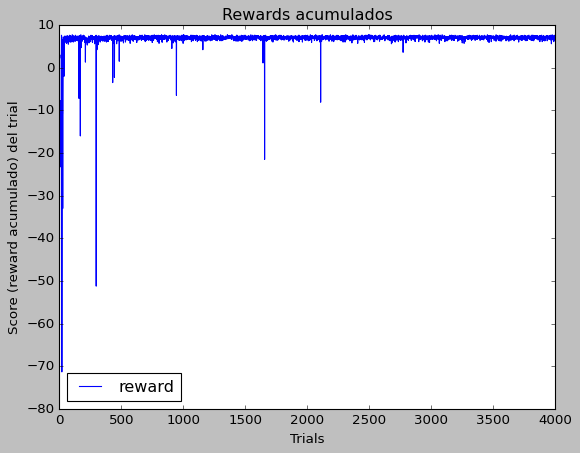

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('classic')
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Rewards acumulados')
ax.set_xlabel("Trials")
ax.set_ylabel("Score (reward acumulado) del trial")
ax.plot(training_rewards,'-', label='reward')
ax.legend(loc='best')
plt.show()

## Obtener la política a partir del agente Q-learning

Primero, debemos extraer las utilidades de los estados a partir de los Q-valores obtenidos por el agente:

In [8]:
def get_utilities_from_qvalues(mdp, Q):
    """Dado un MDP y una funcion de utilidad Q, determina los valores de utilidad de los estados. """
    U = {}
    for s in mdp.states:
        if s not in mdp.terminals:
            U[s] =  -np.inf
            for a in mdp.actionlist:
                if Q[(s, a)] > U[s] : 
                    U[s] = Q[(s, a)]
    return U

In [9]:
U = get_utilities_from_qvalues(environment, agent.Q)
#U

¿Cómo se relacionan las utilidades con los Q-values?

In [10]:
agent.Q

defaultdict(float,
            {((1, 1), None): -4.658061165903668,
             ((1, 3), (-1, 0)): -0.8546278131178651,
             ((1, 3), (0, -1)): -0.8532491629506441,
             ((1, 3), (0, 1)): -0.8478462856185138,
             ((1, 3), (1, 0)): -0.8520239718608875,
             ((1, 4), (-1, 0)): -0.8267150940542468,
             ((1, 4), (0, -1)): -0.831695899082488,
             ((1, 4), (0, 1)): -0.8256085634276306,
             ((1, 4), (1, 0)): -0.8313340838230572,
             ((1, 5), (-1, 0)): -0.8050997895819,
             ((1, 5), (0, -1)): -0.8186155664948892,
             ((1, 5), (0, 1)): -0.8015900931538242,
             ((1, 5), (1, 0)): -0.8149424569633196,
             ((1, 6), (-1, 0)): -0.7793396467613591,
             ((1, 6), (0, -1)): -0.7957687906218217,
             ((1, 6), (0, 1)): -0.7756497176565781,
             ((1, 6), (1, 0)): -0.7758000482969396,
             ((1, 7), (-1, 0)): -0.7661463791593655,
             ((1, 7), (0, -1)): -0.77046656

Luego, generamos una política de acciones a partir de los Q-values obtenidos por el agente:

In [11]:
def get_policy_from_qvalues(mdp, Q):
    """Dado un MDP y una funccion de utilidad Q, determina la mejor politica. """
    pi = {}
    for s in mdp.states:
        if s not in mdp.terminals:
            pi[s] = max(mdp.actionlist, key=lambda a: Q[(s,a)])
        else:
            pi[s] = None
    return pi

In [12]:
pi_qlearning = get_policy_from_qvalues(environment, Qvalues)

In [13]:
environment.print_policy(pi_qlearning)

None   None   None   None   None   None   None   None   None   None   None
None   v      >      v      <      >      v      >      None   .      None
None   v      None   None   None   None   None   None   None   ^      None
None   >      >      >      >      >      >      >      >      ^      None
None   ^      None   None   None   None   None   None   None   None   None
None   ^      None   v      v      >      <      <      >      <      None
None   ^      None   None   None   None   None   ^      None   ^      None
None   ^      <      <      <      <      >      v      None   v      None
None   None   None   None   None   ^      None   <      None   v      None
None   .      >      >      >      ^      None   >      None   >      None
None   None   None   None   None   None   None   None   None   None   None


## Obtener la política usando Value Iteration

In [14]:
# Computa e imprime la politica optima usando value_iteration (este tiene acceso al modelo de transicion) 
from mdp import *  # mdp tiene la implementacion de value iteration
pi_valueiteration = best_policy(environment, value_iteration(environment, .001))

In [15]:
environment.print_policy(pi_valueiteration)

None   None   None   None   None   None   None   None   None   None   None
None   v      <      <      <      <      <      <      None   .      None
None   v      None   None   None   None   None   None   None   ^      None
None   >      >      >      >      >      >      >      >      ^      None
None   ^      None   None   None   None   None   None   None   None   None
None   ^      None   >      >      >      >      v      <      <      None
None   ^      None   None   None   None   None   v      None   ^      None
None   ^      <      <      <      <      <      <      None   ^      None
None   None   None   None   None   ^      None   ^      None   ^      None
None   .      >      >      >      ^      None   ^      None   ^      None
None   None   None   None   None   None   None   None   None   None   None


## Desafío de la semana: Entorno `GridEnvironment` <font color='red'>(2 puntos en total)</font>

1) Cree una función para comparar dos políticas y devolver el número total de estados en los cuales coinciden las políticas. Llame dicha función: `compare_policies(policy1, policy2)`. Pruebe dicha función con `policy1 = pi_qlearning` (la politica obtenida mediante Q-Learning) y `policy2 = pi_valueiteration` la política óptima de resolver el MDP con el metodo `value_iteration` con `Rplus=3`.

In [16]:
pi_qlearning

{(1, 1): None,
 (1, 3): (0, 1),
 (1, 4): (0, 1),
 (1, 5): (0, 1),
 (1, 6): (0, 1),
 (1, 7): (1, 0),
 (1, 8): (0, -1),
 (1, 9): (0, -1),
 (2, 1): (1, 0),
 (2, 3): (-1, 0),
 (2, 7): (1, 0),
 (2, 9): (1, 0),
 (3, 1): (1, 0),
 (3, 3): (-1, 0),
 (3, 5): (0, -1),
 (3, 7): (1, 0),
 (3, 9): (0, -1),
 (4, 1): (1, 0),
 (4, 3): (-1, 0),
 (4, 5): (0, -1),
 (4, 7): (1, 0),
 (4, 9): (-1, 0),
 (5, 1): (0, 1),
 (5, 2): (0, 1),
 (5, 3): (-1, 0),
 (5, 5): (1, 0),
 (5, 7): (1, 0),
 (5, 9): (1, 0),
 (6, 3): (1, 0),
 (6, 5): (-1, 0),
 (6, 7): (1, 0),
 (6, 9): (0, -1),
 (7, 1): (1, 0),
 (7, 2): (-1, 0),
 (7, 3): (0, -1),
 (7, 4): (0, 1),
 (7, 5): (-1, 0),
 (7, 7): (1, 0),
 (7, 9): (1, 0),
 (8, 5): (1, 0),
 (8, 7): (1, 0),
 (9, 1): (1, 0),
 (9, 2): (0, -1),
 (9, 3): (0, -1),
 (9, 4): (0, 1),
 (9, 5): (-1, 0),
 (9, 7): (0, 1),
 (9, 8): (0, 1),
 (9, 9): None}

In [17]:
pi_valueiteration

{(1, 1): None,
 (1, 3): (0, 1),
 (1, 4): (0, 1),
 (1, 5): (0, 1),
 (1, 6): (0, 1),
 (1, 7): (1, 0),
 (1, 8): (0, -1),
 (1, 9): (0, -1),
 (2, 1): (1, 0),
 (2, 3): (-1, 0),
 (2, 7): (1, 0),
 (2, 9): (-1, 0),
 (3, 1): (1, 0),
 (3, 3): (-1, 0),
 (3, 5): (1, 0),
 (3, 7): (1, 0),
 (3, 9): (-1, 0),
 (4, 1): (1, 0),
 (4, 3): (-1, 0),
 (4, 5): (1, 0),
 (4, 7): (1, 0),
 (4, 9): (-1, 0),
 (5, 1): (0, 1),
 (5, 2): (0, 1),
 (5, 3): (-1, 0),
 (5, 5): (1, 0),
 (5, 7): (1, 0),
 (5, 9): (-1, 0),
 (6, 3): (-1, 0),
 (6, 5): (1, 0),
 (6, 7): (1, 0),
 (6, 9): (-1, 0),
 (7, 1): (0, 1),
 (7, 2): (0, 1),
 (7, 3): (-1, 0),
 (7, 4): (0, -1),
 (7, 5): (0, -1),
 (7, 7): (1, 0),
 (7, 9): (-1, 0),
 (8, 5): (-1, 0),
 (8, 7): (1, 0),
 (9, 1): (0, 1),
 (9, 2): (0, 1),
 (9, 3): (0, 1),
 (9, 4): (0, 1),
 (9, 5): (-1, 0),
 (9, 7): (0, 1),
 (9, 8): (0, 1),
 (9, 9): None}

### Funcion de comparacion de políticas: <font color='red'>1 punto</font>

In [22]:
def compare_policies(policy1, policy2):
    # Las políticas ingresadas son  diccionarios cuyos elementos tienen la estructura: `state: action`
    # TODO:  Esta es la parte que debe completar. Debe devolver una tupla con dos resultados:
    # el numero de acciones coincidentes entre polÍticas, y la cantidad total de estados de ambas políticas
    # Observación: se asume que ambas políticas ingresadas tienen la misma cantidad de estados
    equal_actions = {k: policy1[k] for k in policy1 if k in policy2 and policy1[k] == policy2[k]}
    total_equal_actions = len(equal_actions)
    total_states = len(policy1)
    return (total_equal_actions, total_states)

In [24]:
num_acciones_coincidentes, num_acciones = compare_policies(pi_qlearning, pi_valueiteration)
print("El número de acciones coincidentes es {} de un total de {} estados".format(num_acciones_coincidentes, num_acciones))

El número de acciones coincidentes es 31 de un total de 49 estados


In [ ]:
49+32

81

### Elección del valor de `Ne` con una iteración y varios trials

2) Ejecute el agente durante 10000 trials para cada uno de los siguientes valores de `Ne`: {0, 1, 5, 10, 50, 100}; y compare las políticas obtenidas en relación a la política óptima de `value_iteration` (`pi_valueiteration`) con `Rplus=3`. Completar la tabla con los resultados obtenidos. ¿Cuál valor de `Ne` genera resultados más próximos a la política óptima?.

En esta parte, la tarea será determinar cuál es el mejor valor para el hiperparámetro `Ne`.

| `Ne` | Cantidad de acciones que coinciden con la política óptima |
| :------- | :------: | 
|  0   | ?       | 
|  1   | ?       | 
|  5   | ?       | 
|  10  | ?       | 
|  50  | ?       | 
| 100  | ?       | 


En esta parte, para cada valor de `Ne`, se va a ejecutar una iteración, cada una con 10000 trials.

#### Completar el código solicitado: <font color='red'>0.25 puntos</font>


Valor de `Ne` elegido: XXX

In [25]:
TRIALS = 10000

In [32]:
lista_Ne = [0,1,5,10,50,100] # Valores de Ne que vamos a probar
lista_Qvalues = []
lista_num_acciones_coinc = {} # Diccionario que va a almacenar la cantidad de acciones coincidentes (value), para cada valor de Ne (key)

for value_Ne in lista_Ne:
    print('\n')
    print('-'*150)
    print('Ne = ',value_Ne)
    print('-'*150)

    # Instancia el entorno del grid
    env = GridEnvironment(grid, terminals=[(1, 1), (9, 9)], initial=(3, 1), gamma=0.9)
    # Instancia un agente Q-learning 
    agent = QLearningAgent(env, Ne=value_Ne, Rplus=2, alpha=lambda n: 60./(59+n))

    # Ejecuta episodios del agente en el entorno
    training_rewards = []
    for e in range(TRIALS):   # Por cada trial
        current_state, current_reward = env.reset()
        score_trial = current_reward   # el score del episodio es la suma acumulada de rewards en el episodio 
        while True:  # ejecuta steps del entorno hasta llegar a un estado terminal
            percept = (current_state, current_reward)  # la percepcion del agente es la tupla (state, reward)
            action  = agent(percept)  # llama al programa del agente, pasandole el percept y espera una accion a ejecutar
            current_state, current_reward, done = env.step(action) # ejecuta la accion en el entorno, 
            score_trial += current_reward
            if done:
                print("Trial: {}/{}, Score: {}".format(e, TRIALS, score_trial))
                training_rewards.append(score_trial)
                break

    # Grabamos los Q vals resultantes
    Qvalues_result = agent.Q

    # Agregamos los Q vals a la lista
    lista_Qvalues.append(Qvalues_result)

    # Comparando las Politicas usando la función que hemos creado
    pi_qlearning_result = get_policy_from_qvalues(env, Qvalues_result)
    pi_valueiteration_result = best_policy(env, value_iteration(env, .001))
    
    # Impirmimos las políticas resultantes
    #env.print_policy(pi_qlearning_result)
    #env.print_policy(pi_valueiteration_result)

    print("Política obtenida con este valor de Ne:",pi_qlearning_result)
    print("Política óptima (según value iteration):", pi_valueiteration_result)

    # Comparando las Politicas usando la función que hemos creado    
    num_acciones_coinc,_ = compare_policies(pi_qlearning_result, pi_valueiteration_result)

    # Agregamos la cantidad de acciones coincidentes al diccionario
    lista_num_acciones_coinc[value_Ne] = num_acciones_coinc
    print('\n',"Número de acciones coindicentes con la política óptima:", lista_num_acciones_coinc[value_Ne])

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Trial: 5004/10000, Score: 6.899999999999999
Trial: 5005/10000, Score: 7.6
Trial: 5006/10000, Score: 7.099999999999999
Trial: 5007/10000, Score: 6.799999999999999
Trial: 5008/10000, Score: 7.499999999999999
Trial: 5009/10000, Score: 6.899999999999999
Trial: 5010/10000, Score: 6.799999999999999
Trial: 5011/10000, Score: 7.399999999999999
Trial: 5012/10000, Score: 6.899999999999999
Trial: 5013/10000, Score: 7.199999999999999
Trial: 5014/10000, Score: 7.399999999999999
Trial: 5015/10000, Score: 7.099999999999999
Trial: 5016/10000, Score: 7.499999999999999
Trial: 5017/10000, Score: 5.999999999999998
Trial: 5018/10000, Score: 7.6
Trial: 5019/10000, Score: 7.199999999999999
Trial: 5020/10000, Score: 6.999999999999998
Trial: 5021/10000, Score: 7.6
Trial: 5022/10000, Score: 7.299999999999999
Trial: 5023/10000, Score: 7.499999999999999
Trial: 5024/10000, Score: 6.899999999999999
Trial: 5025/10000, Score: 7.399999999999999
Trial: 

In [33]:
lista_Ne = [0,1,5,10,50,100] # Valores de Ne que vamos a probar
lista_Qvalues = []
lista_num_acciones_coinc = {} # Diccionario que va a almacenar la cantidad de acciones coincidentes (value), para cada valor de Ne (key)

for value_Ne in lista_Ne:
    print('\n')
    print('-'*150)
    print('Ne = ',value_Ne)
    print('-'*150)

    # Instancia el entorno del grid
    env = GridEnvironment(grid, terminals=[(1, 1), (9, 9)], initial=(3, 1), gamma=0.9)
    # Instancia un agente Q-learning 
    agent = QLearningAgent(env, Ne=value_Ne, Rplus=2, alpha=lambda n: 60./(59+n))

    # Ejecuta episodios del agente en el entorno
    training_rewards = []
    for e in range(TRIALS):   # Por cada trial
        current_state, current_reward = env.reset()
        score_trial = current_reward   # el score del episodio es la suma acumulada de rewards en el episodio 
        while True:  # ejecuta steps del entorno hasta llegar a un estado terminal
            percept = (current_state, current_reward)  # la percepcion del agente es la tupla (state, reward)
            action  = agent(percept)  # llama al programa del agente, pasandole el percept y espera una accion a ejecutar
            current_state, current_reward, done = env.step(action) # ejecuta la accion en el entorno, 
            score_trial += current_reward
            if done:
                # print("Trial: {}/{}, Score: {}".format(e, TRIALS, score_trial))
                training_rewards.append(score_trial)
                break

    # Grabamos los Q vals resultantes
    Qvalues_result = agent.Q

    # Agregamos los Q vals a la lista
    lista_Qvalues.append(Qvalues_result)

    # Comparando las Politicas usando la función que hemos creado
    pi_qlearning_result = get_policy_from_qvalues(env, Qvalues_result)
    pi_valueiteration_result = best_policy(env, value_iteration(env, .001))
    
    # Impirmimos las políticas resultantes
    #env.print_policy(pi_qlearning_result)
    #env.print_policy(pi_valueiteration_result)

    print("Política obtenida con este valor de Ne:",pi_qlearning_result)
    print("Política óptima (según value iteration):", pi_valueiteration_result)

    # Comparando las Politicas usando la función que hemos creado    
    num_acciones_coinc,_ = compare_policies(pi_qlearning_result, pi_valueiteration_result)

    # Agregamos la cantidad de acciones coincidentes al diccionario
    lista_num_acciones_coinc[value_Ne] = num_acciones_coinc
    print('\n',"Número de acciones coindicentes con la política óptima:", lista_num_acciones_coinc[value_Ne])



------------------------------------------------------------------------------------------------------------------------------------------------------
Ne =  0
------------------------------------------------------------------------------------------------------------------------------------------------------
Política obtenida con este valor de Ne: {(5, 9): (1, 0), (4, 7): (1, 0), (1, 3): (1, 0), (7, 3): (1, 0), (9, 1): (1, 0), (9, 8): (1, 0), (7, 7): (1, 0), (2, 1): (-1, 0), (1, 6): (1, 0), (3, 7): (1, 0), (5, 1): (0, 1), (8, 5): (1, 0), (5, 8): (1, 0), (1, 2): (1, 0), (4, 9): (1, 0), (3, 3): (1, 0), (2, 9): (1, 0), (5, 5): (1, 0), (6, 7): (1, 0), (7, 6): (1, 0), (6, 3): (1, 0), (1, 5): (1, 0), (4, 1): (0, 1), (1, 1): None, (9, 7): (1, 0), (7, 1): (1, 0), (4, 5): (1, 0), (9, 3): (1, 0), (1, 4): (1, 0), (3, 9): (1, 0), (2, 3): (1, 0), (1, 9): (1, 0), (7, 5): (1, 0), (9, 6): (1, 0), (6, 5): (1, 0), (3, 5): (1, 0), (2, 7): (1, 0), (5, 3): (1, 0), (7, 9): (1, 0), (8, 3): (1, 0), (9, 2): 

In [34]:
lista_num_acciones_coinc

{0: 20, 1: 27, 5: 21, 10: 28, 50: 20, 100: 29}

Calculamos la mayor cantidad de acciones coincidentes:

In [35]:
max_v = max(lista_num_acciones_coinc.values())

Calculamos el valor de `Ne` que corresponde a la cantidad de acciones `max_v`:

In [36]:
for Ne in lista_num_acciones_coinc.keys():
    if max_v == lista_num_acciones_coinc[Ne]:
        Ne_elegido = Ne
        print("El mejor Ne es",Ne_elegido)

El mejor Ne es 100


Mostramos los datos en un pandas DataFrame:

In [37]:
import pandas 
tabla = pandas.DataFrame()

tabla['Ne'] = list(lista_num_acciones_coinc.keys())
tabla['Cantidad de acciones que coinciden con la política óptima'] = list(lista_num_acciones_coinc.values())
tabla

,Ne,Cantidad de acciones que coinciden con la política óptima
0,0,20
1,1,27
2,5,21
3,10,28
4,50,20
5,100,29


#### Elegir el valor de `Ne` de acuerdo a sus resultados obtenidos: <font color='red'>0.25 puntos</font>

Resultados finales:

In [38]:
print("Valor de Ne elegido:", Ne_elegido)
print("Para este valor,", max_v, "acciones coinciden con las acciones que indica la política óptima")

Valor de Ne elegido: 100
Para este valor, 29 acciones coinciden con las acciones que indica la política óptima


Se selecciona el valor de `Ne` que genere la mayor cantidad de acciones que coinciden con la política óptima, según los resultados que hayas obtenido en tu notebook.

De acuerdo a los resultados del cuadernillo, el valor de `Ne` elegido es `...`.

### Elección del valor de `Ne` con varias iteraciones y varios trials por iteración

In [39]:
cantidad_busquedas_Ne = 100

En esta parte, para cada valor de `Ne`, se van a ejecutar 100 iteraciones, cada una con 10000 trials.

#### Completar el código solicitado: <font color='red'>0.25 puntos</font>

In [41]:
%%time
#lista_Ne = [0,1,5,10,50,100] # ya lo definimos arriba
num_veces_elegido = [0]*len(lista_Ne)
registro_total_cant = []

for i in range(cantidad_busquedas_Ne):

    lista_Qvalues = []
    lista_num_acciones_coinc = {}

    for value_Ne in lista_Ne:
        # Instancia el entorno del grid
        env = GridEnvironment(grid, terminals=[(1, 1), (9, 9)], initial=(3, 1), gamma=0.9)
        
        # Instancia un agente Q-learning 
        agent = QLearningAgent(env, Ne=value_Ne, Rplus=2, alpha=lambda n: 60./(59+n))

        # Ejecuta episodios del agente en el entorno
        training_rewards = []
        for e in range(TRIALS):   # Por cada trial
          current_state, current_reward = env.reset()
          score_trial = current_reward   # el score del episodio es la suma acumulada de rewards en el episodio 
          while True:  # ejecuta steps del entorno hasta llegar a un estado terminal
              percept = (current_state, current_reward)  # la percepcion del agente es la tupla (state, reward)
              action  = agent(percept)  # llama al programa del agente, pasandole el percept y espera una accion a ejecutar
              current_state, current_reward, done = env.step(action) # ejecuta la accion en el entorno, 
              score_trial += current_reward
              if done:
                  # print("Trial: {}/{}, Score: {}".format(e, TRIALS, score_trial))
                  training_rewards.append(score_trial)
                  break

        # Grabamos los Q vals resultantes
        Qvalues_result = agent.Q

        # Agregamos los Q vals a la lista
        lista_Qvalues.append(Qvalues_result)

        # Comparando las Politicas usando la función que hemos creado
        pi_qlearning_result = get_policy_from_qvalues(env, Qvalues_result)
        pi_valueiteration_result = best_policy(env, value_iteration(env, .001))
        
        # Impirmimos las políticas resultantes
        #env.print_policy(pi_qlearning_result)
        #env.print_policy(pi_valueiteration_result)

        #print("Política obtenida con este valor de Ne:",pi_qlearning_result)
        #print("Política óptima (según value iteration):", pi_valueiteration_result)

        # Comparando las Politicas usando la función que hemos creado    
        num_acciones_coinc,_ = compare_policies(pi_qlearning_result, pi_valueiteration_result)

        # Agregamos la cantidad de acciones coincidentes al diccionario
        lista_num_acciones_coinc[value_Ne] = num_acciones_coinc
        #print('\n',"Número de acciones coindicentes con la política óptima:", num_acciones_coinc)

    registro_total_cant.append( list(lista_num_acciones_coinc.values()) )

    max_v = max(lista_num_acciones_coinc.values())
    for Ne in lista_num_acciones_coinc.keys():
        if max_v == lista_num_acciones_coinc[Ne]:
            Ne_elegido = Ne
            print("Iteración",i+1,": El mejor Ne es",Ne)

    indice_Ne_elegido = lista_Ne.index(Ne_elegido)
    num_veces_elegido[indice_Ne_elegido] += 1

Iteración 1 : El mejor Ne es 10
Iteración 2 : El mejor Ne es 10
Iteración 3 : El mejor Ne es 1
Iteración 4 : El mejor Ne es 1
Iteración 4 : El mejor Ne es 10
Iteración 5 : El mejor Ne es 1
Iteración 6 : El mejor Ne es 10
Iteración 7 : El mejor Ne es 10
Iteración 8 : El mejor Ne es 1
Iteración 9 : El mejor Ne es 1
Iteración 9 : El mejor Ne es 10
Iteración 10 : El mejor Ne es 10
Iteración 11 : El mejor Ne es 1
Iteración 12 : El mejor Ne es 1
Iteración 13 : El mejor Ne es 1
Iteración 14 : El mejor Ne es 1
Iteración 15 : El mejor Ne es 1
Iteración 16 : El mejor Ne es 10
Iteración 17 : El mejor Ne es 1
Iteración 18 : El mejor Ne es 1
Iteración 18 : El mejor Ne es 10
Iteración 19 : El mejor Ne es 100
Iteración 20 : El mejor Ne es 1
Iteración 21 : El mejor Ne es 1
Iteración 21 : El mejor Ne es 10
Iteración 22 : El mejor Ne es 1
Iteración 23 : El mejor Ne es 1
Iteración 24 : El mejor Ne es 1
Iteración 25 : El mejor Ne es 1
Iteración 25 : El mejor Ne es 10
Iteración 26 : El mejor Ne es 10
Itera

Existen casos en donde para más de un valor de `Ne`, se obtiene el mismo número de acciones coincidentes con la política óptima.

Usando pandas, crear la siguiente tabla:

In [42]:
import pandas 
tabla2 = pandas.DataFrame()

tabla2['Ne'] = list(lista_num_acciones_coinc.keys())
tabla2['Número de veces que fue elegido como el mejor Ne'] = num_veces_elegido

tabla2

,Ne,Número de veces que fue elegido como el mejor Ne
0,0,0
1,1,58
2,5,0
3,10,37
4,50,0
5,100,5


In [43]:
indice_best_Ne_final = num_veces_elegido.index(max(num_veces_elegido))
Ne_elegido_final = lista_Ne[indice_best_Ne_final]

In [44]:
print("Valor FINAL de Ne elegido:", Ne_elegido_final)

Valor FINAL de Ne elegido: 1


Por otro lado, se podría considerar también la media y desviación estándar de los resultados en varias iteraciones para elegir con un criterio de mejor validez estadística (no simplemente tomar la moda del valor máximo).

In [45]:
np_registro_total_cant = np.array(registro_total_cant)
np_registro_total_cant.shape

(100, 6)

Mostramos la cantidad de acciones coincidentes con la política óptima en las primeras 5 ejecuciones.

In [46]:
np_registro_total_cant[:5]

array([[20, 30, 21, 33, 20, 27],
       [21, 29, 21, 31, 21, 26],
       [22, 34, 21, 32, 22, 27],
       [21, 31, 21, 31, 21, 27],
       [21, 29, 24, 27, 20, 26]])

In [47]:
tabla_all_executions = pandas.DataFrame(np_registro_total_cant, columns=lista_num_acciones_coinc.keys())
tabla_all_executions.describe()

,0,1,5,10,50,100
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,21.25000,31.730000,21.170000,30.580000,20.840000,27.990000
std,1.05768,2.078534,0.964575,1.781952,0.813025,1.259269
min,20.00000,28.000000,20.000000,27.000000,20.000000,26.000000
25%,20.00000,30.000000,21.000000,29.000000,20.000000,27.000000
50%,21.00000,31.000000,21.000000,30.500000,21.000000,28.000000
75%,22.00000,33.000000,22.000000,32.000000,21.000000,29.000000
max,24.00000,36.000000,24.000000,36.000000,23.000000,32.000000


#### Elegir el mejor valor de `Ne` según el boxplot: <font color='red'>0.25 puntos</font>

Observamos una gráfica con la distribución estadística de los resultados, luego de 100 experimentos:

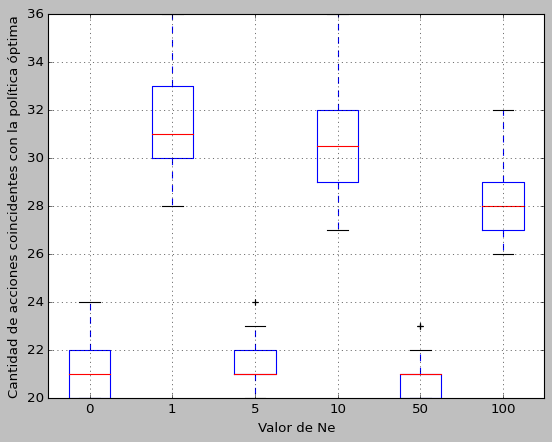

In [48]:
ax = tabla_all_executions.boxplot()
ax.set_xlabel("Valor de Ne")
ax.set_ylabel("Cantidad de acciones coincidentes con la política óptima")
plt.show()

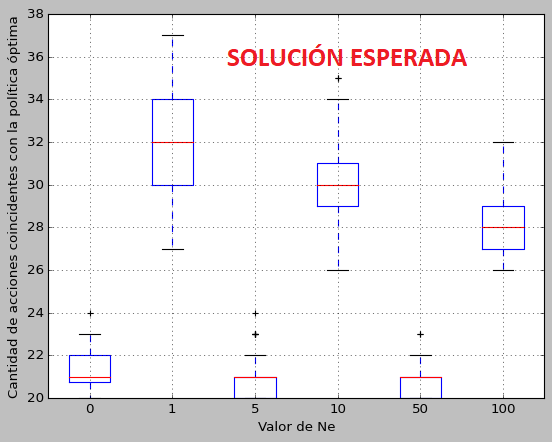

Estadísticamente, elegimos ... 10 debido a que su distribución es más pareja por su posición y también esta más concentrada por su tamaño.